In [187]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Loading results dataframes for use in linear regression modeling
run_data = pd.read_csv("data/stream-data/raw-stream-data/russian.csv", thousands=',')
days_below_32 = pd.read_csv("data/weather-data/KenaiAirport_Days-Below-32F.csv")
summer_mean_temps = pd.read_csv("data/weather-data/KenaiAirport_Summer-Mean-Temps-Yearly.csv")
winter_mean_temps = pd.read_csv("data/weather-data/KenaiAirport_Winter-Mean-Temps-Yearly.csv")
input_data = pd.merge(left=days_below_32, right=summer_mean_temps, left_on='year', right_on='year')
input_data = pd.merge(left=input_data, right=winter_mean_temps, left_on='year', right_on='year')

Now that we have our data loaded and the proper modules imported, let's process the Russian
River run datafile to parse out our target output variables (run counts) as well as gather a 
few more potential input variables (effort counts or "angler days").

In [188]:
drop_columns = ['ER  Escapement', 'LR Escapement', 'ER', 'LR']
run_data.drop(columns=drop_columns, inplace=True)
run_data.rename(columns={'Year' : 'year'}, inplace=True)
# merge with the input_data frame
model_data = pd.merge(left=input_data, right=run_data, left_on='year', right_on='year')
# dropping the year with no Effort value
model_data.drop(index=0, inplace=True)
model_data['Effort'] = model_data['Effort'].str.replace(',', '').astype(int)
model_data.dtypes

year                  int64
days_below_32         int64
mean_summer_temp    float64
mean_winter_temp    float64
Effort                int32
ER Sport              int64
LR Sport              int64
ER Local              int64
LR Local              int64
Total Run             int64
dtype: object

Now we need to timelag the Effort column for 3 years prior (average life of salmon before returning).
This allows the effort values of prior years to be used as a predictor for future runs.

In [189]:
def get_effort_3_years_ago(row):
    target_year = row.year - 3
    try:
        return model_data[model_data['year'] == target_year].iloc[0]['Effort']
    except:
        return None

temp_data = model_data.drop(index=[1,2,3])
temp_data['effort_3_years_ago'] = temp_data.apply(get_effort_3_years_ago, axis=1)
temp_data
    

,year,days_below_32,mean_summer_temp,mean_winter_temp,Effort,ER Sport,LR Sport,ER Local,LR Local,Total Run,effort_3_years_ago
4,1966,132,51.144022,11.791667,18280,14950,7290,31608,41720,73328,7880.0
5,1967,100,51.691382,11.194444,16960,7240,5720,20950,55200,76150,5330.0
6,1968,96,53.985054,9.709341,17280,6920,5820,16112,54700,70812,9720.0
7,1969,83,53.339946,14.041667,14930,5870,1150,10870,30022,40892,18280.0
8,1973,126,49.922518,6.843829,30690,6740,8930,19860,33998,53858,NaN
9,1974,121,51.852684,10.105652,21120,6440,8500,19604,33404,53008,NaN
10,1975,140,50.864420,5.378752,16510,1400,8390,7045,40351,47396,NaN
11,1976,99,52.248856,14.913558,26310,3380,13700,18116,45639,63755,30690.0
12,1977,110,53.603950,21.188563,69510,20400,27440,36461,48802,85263,21120.0
13,1978,76,50.942544,20.675032,69860,37720,24530,71960,58864,130824,16510.0


Let's take a look at the correlations between our dataset to see if we can identify any
potential collinearity that will allow us to simply our input complexity.

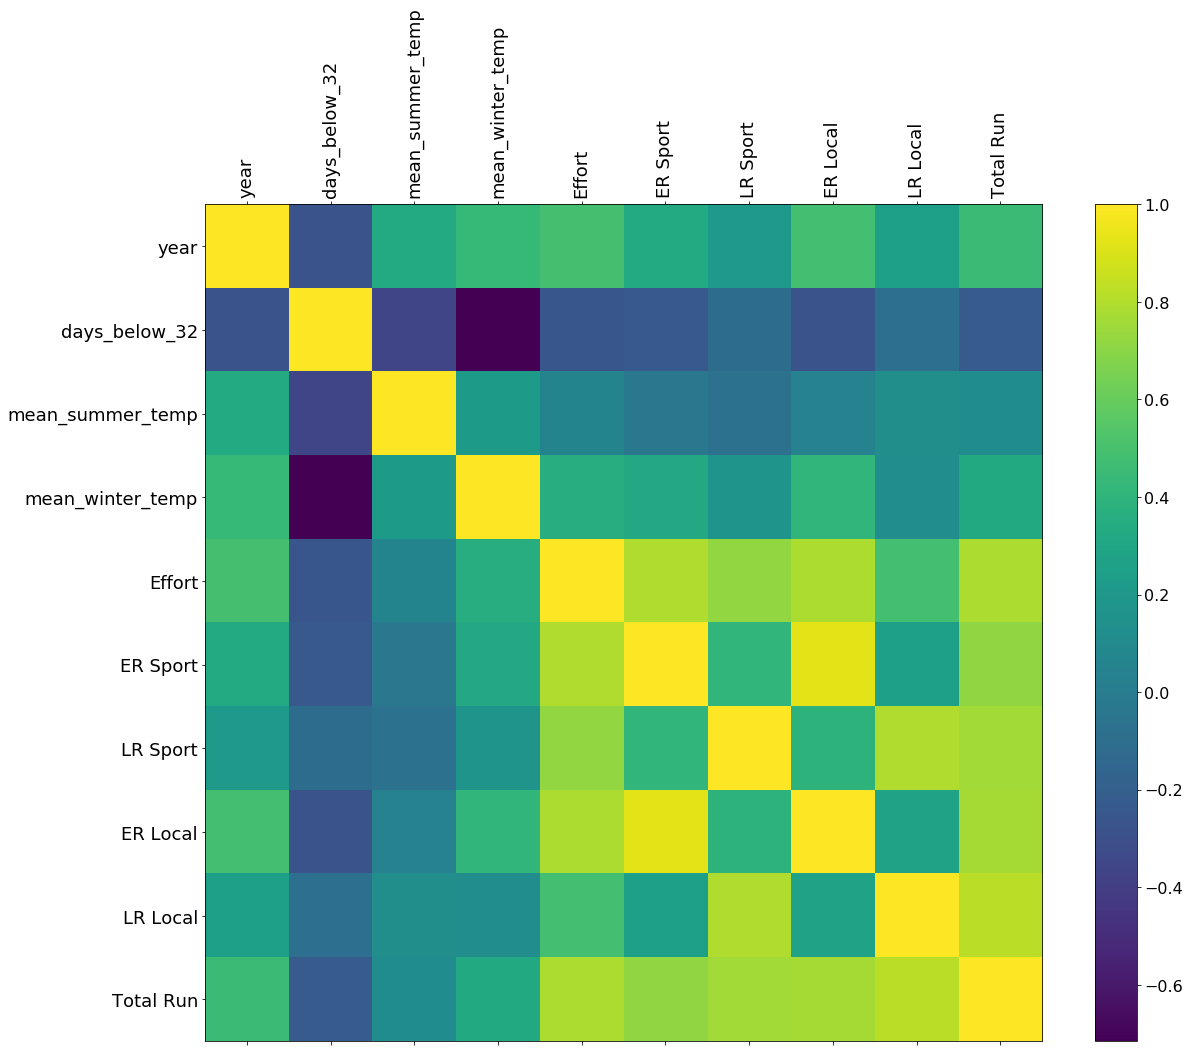

In [190]:
matrix = model_data.corr()
correlations = plt.figure(figsize=(19,15))
plt.matshow(matrix, fignum=correlations.number)
plt.xticks(range(model_data.shape[1]), model_data.columns, rotation=90, fontsize=18)
plt.yticks(range(model_data.shape[1]), model_data.columns, fontsize=18)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)